# GAP range map evaluation: Worm-eating Warbler
This notebook details a framework for evaluating GAP range maps with occurrence data retrieved from databases such as GBIF via APIs.  It details the major steps and features of the framework for a single species: the yellow-billed cuckoo.  The primary results are some maps for visualization, columns added to a GAP range data .csv file that is downloaded from ScienceBase, and documentation of decisions and archiving of data used. 

See the README.md file in this repository for more information.

There are a few major steps:  

### Range Evaluation Parameter Database
This process requires some decision making about how to filter the records and other things.  Such decisions are documented in a database that can be queried in the other steps and referred to later for reference.

### Evaluate GAP Known Range Data
GAP ranges exist in table form in a database and on ScienceBase.  Ranges can be compared to occurrence circles to find HUCs where GAP was correct about species' presence and where it was wrong about absence.  The results of those comparisons can be saved in columns in the range tables.

### Automated Range Delineation?
The occurrence record database populated for range evaluation could also be a source for range delineation: either by an expert or with an automated process.  Spatialite has a concave hull function that can be deployed.  I generated seasonal, yearly, and monthly range maps with that process, but they were of poor quality. 

### General Setup
Some parameters need to be declared, including a unique name for this evaluation.  

In [1]:
%matplotlib inline
import sqlite3
import pprint
import pandas as pd
#import geopandas as gpd
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.max_rows', 100)
from IPython.display import Image
import config
import repo_functions as functions
from pygbif import occurrences
import matplotlib.pyplot as plt

gap_id = 'bwewax'
species_id = 'bwewax0'
inDir = '/users/nmtarr/documents/ranges/inputs/'
outDir = '/users/nmtarr/documents/ranges/outputs/'
summary_name = 'wormie' # an short, memorable name to use for file names etc.
years = '2014-2019'
eval_id = 'eval_gbif1'
request_id = 'GBIFr16'
filter_id = 'GBIFf4'

## 1. Range Evaluation Parameter Database

Descriptions of all the columns in the databse are listed below.  As more filtering parameters are explored and employed for each data source, they will need to be described.  The database is currently stored locally but would eventually need to be on a server.

The database description and schema is printed below.

In [5]:
connjup = sqlite3.connect('/users/nmtarr/code/occurrence-record-wrangler/parameters.sqlite')
cursorjup = connjup.cursor()
"""
table_names = cursorjup.execute("SELECT DISTINCT table_name FROM column_descriptions;").fetchall()
for table in table_names:
    table = table[0]
    tbl_desc = cursorjup.execute("SELECT description FROM table_descriptions WHERE table_name='{0}';".format(table)).fetchone()
    print("\n","-"*80,"\n\n",table.upper(),"TABLE\n",str(tbl_desc[0]),"\n")
    print(" COLUMNS")
    print(" Id, Column Name, Data Type, Not Null, Default, Unique")
    pprint.pprint(cursorjup.execute("PRAGMA table_info('{0}');".format(table)).fetchall())
    df = cursorjup.execute("SELECT * FROM column_descriptions WHERE table_name='{0}'".format(table)).fetchall()
    for row in df:
        print('\n' + row[1] + ' -- ' + row[2])
"""

'\ntable_names = cursorjup.execute("SELECT DISTINCT table_name FROM column_descriptions;").fetchall()\nfor table in table_names:\n    table = table[0]\n    tbl_desc = cursorjup.execute("SELECT description FROM table_descriptions WHERE table_name=\'{0}\';".format(table)).fetchone()\n    print("\n","-"*80,"\n\n",table.upper(),"TABLE\n",str(tbl_desc[0]),"\n")\n    print(" COLUMNS")\n    print(" Id, Column Name, Data Type, Not Null, Default, Unique")\n    pprint.pprint(cursorjup.execute("PRAGMA table_info(\'{0}\');".format(table)).fetchall())\n    df = cursorjup.execute("SELECT * FROM column_descriptions WHERE table_name=\'{0}\'".format(table)).fetchall()\n    for row in df:\n        print(\'\n\' + row[1] + \' -- \' + row[2])\n'

## 2. Species Concepts
Species concepts of interest need to be matched up with concepts used by data sources.  The BCB's Taxa Information Registry can likely facilitate this in the future.  The species concept lists used here will be saved in the parameters database.  For development purposes, I have manually entered one species but this step can be developed more fully later.

Note the field for species geometry that could be used to apply a spatial filter to records that would exclude records that are in far-off or impossible locations.

In [6]:
#%run 'id_species_concepts.py'

In [7]:
vals = cursorjup.execute("SELECT * FROM species_concepts WHERE species_id = '{0}';".format(species_id)).fetchall()
cols = [x[1] for x in cursorjup.execute("PRAGMA table_info('species_concepts')").fetchall()]
pprint.pprint(dict(zip(cols, vals)))

{'species_id': ('bwewax0',
                '',
                'bwewax',
                '726195',
                '2489603',
                None,
                'worm-eating warbler',
                'Helmitheros vermivorum',
                2003,
                None,
                None,
                200,
                1,
                20,
                '1',
                '5,6,7',
                '10,11,12,1,2',
                'Species name changed from vermivorus in 2003.  Breeding and '
                'wintering months from Birds of North America Database (July '
                '26, 2019).  Migration is possible in early May and late July. '
                'N. Tarr 26 July 2019.')}


# 3. Retrieve and Filter Occurrence Data
Data can be retrieved through APIs, but it needs to be filtered.  Many options for filtering exist and are data source specific, so decisions have to be made about how to filter.  In this framework, I am proposing that filters be treated as unique entities (__filter sets__) that are stored and documented in the rng_eval_params database.  Doing so provides a way to link data sets used for range evaluation (or delineation) back to the decisions made when aquiring them.  Filter sets would be documented in tables specific to the data source and step of filtering; so far, gbif_requests and gbif_filters are such tables.  This example is using filter sets __'r001'__ (request filter) and __'f001'__ (post-request filter).  

In [8]:
df1 = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id = '{0}'".format(request_id), con=connjup)
print("REQUEST FILTER SET")
print(df1.loc[0])

REQUEST FILTER SET
request_id                     GBIFr16
source                            GBIF
lat_range                        27,41
lon_range                      -91,-75
years_range                  2014,2019
months_range                      1,12
geoissue                         False
coordinate                        True
continent                         None
creator                        N. Tarr
notes           From the last 5 years.
Name: 0, dtype: object


In [9]:
df2 = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{}'".format(filter_id), con=connjup)
print("POST REQUEST FILTER SET")
print(df2.loc[0])

POST REQUEST FILTER SET
filter_id                                                                          GBIFf4
dataset                                                                              GBIF
collection_codes_omit                                                                None
institutions_omit                                                                    None
has_coordinate_uncertainty                                                              0
max_coordinate_uncertainty                                                           5000
bases_omit                                            PRESERVED_SPECIMEN, FOSSIL_SPECIMEN
protocols_omit                                                                       None
sampling_protocols_omit                                                              None
issues_omit                   GEODETIC_DATUM_INVALID, INDIVIDUAL_COUNT_INVALID, MULTIM...
creator                                                                     

In [10]:
# Run a script that retrieves and filters
%run 'retrieve_occurrences.py'

"""
Needs to connect to a database and then create a shapefile that can be displayed below.
"""

SELECT gbif_id, common_name, scientific_name,
                    detection_distance_meters, gap_id
             FROM species_concepts
             WHERE species_id = 'bwewax0';


IndexError: list index out of range

At this point, records have been retrieved, filtered, buffered, and stored in a database.  They are displayed below on a map with the GAP range map.

In [ ]:
gap_range2 = "{0}{1}_range_4326".format(inDir, gap_id)

shp1 = {'file': gap_range2, 'column': None, 'alias': 'GAP range map',
        'drawbounds': False, 'linewidth': .5, 'linecolor': 'y',
        'fillcolor': 'y', 'marker':'s'}

shp2 = {'file': '{0}{1}_circles'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'k',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
title="Worm-eating Warbler ({0})".format(years)
functions.MapShapefilePolygons(map_these=[shp1, shp2], title=title)

# 4. Evaluate GAP Known Range Data
The first step in using occurrence records to evaluate GAP range is to build another database to hold the GAP 12 digit HUCs and range for the species, as well as for performing the necessary spatial queries.  The GAP range is retrieved from ScienceBase and the HUCs would be too if they were available as a shapefile.  

In [ ]:
#%run 'make_range_evaluation_db.py'

As with the filter sets, parameters for evaluation have to be set/decided upon.  I am proposing that evaluation parameter sets also be documented as unique entities in a database (i.e, rng_eval_params).  Each evaluation can be given a unique id that can be used in documentation, file naming, and for the names of the columns that will be added to the GAP range table to record the results of the evaluation.  In this example, the evaluation_id is __eval_gbif1__.  It's definition is printed below.

In [ ]:
df3 = pd.read_sql_query(sql="SELECT * FROM evaluations WHERE evaluation_id = 'eval_gbif1'", con=connjup)
df3.loc[0, 'years'] = df3.loc[0, 'years'][0:4] + '-' + df3.loc[0, 'years'][-4:]
print("\nEVALUATION PARAMETERS")
print(df3.loc[0])

Next, buffered occurrence point circles can be spatially compared against the HUC layer in order to determine which HUCs they can be attributed to.  After they are attributed to HUCs, the results can be recorded in the species' range map table in terms of whether the two data sets agreed and whether they validate the GAP range data for any HUCs.  

For each evaluation, a column is added for 1) how many records could be attributed to each huc and 2) whether there is agreement at that huc (1 for yes, 0 for no, 'None' for no data for that huc) and 3) whether the GAP range has been validated by the evaluation.

Evaluations are unique entities composed of filtered data and evaluation methods and parameters.  For this example, the method used was intersection with an error tolerance of 40% during the intersection.  That means that an occurrence was attributed to a HUC when > 60% of the occurrence circle occurred in the HUC.  The figure below illustrates how this plays out: circles are occurrence polygons, blue polygons are hucs, and numbers tell how many occurrences were attributed to the huc.  Note that that huc with 3 occurrences contains 3 small occurrence circles that are identical and therefore appear as one.  A "min_count" is applied in the evaluation too so that HUCs with a number of occurrences > than the min_count are considered to indicate agreement.  This is a way to mediate the influence of false positives and other sporadic errors.  min_counts can be set at the species level or evaluation level.

The 'proportion in polygon method' illustrated


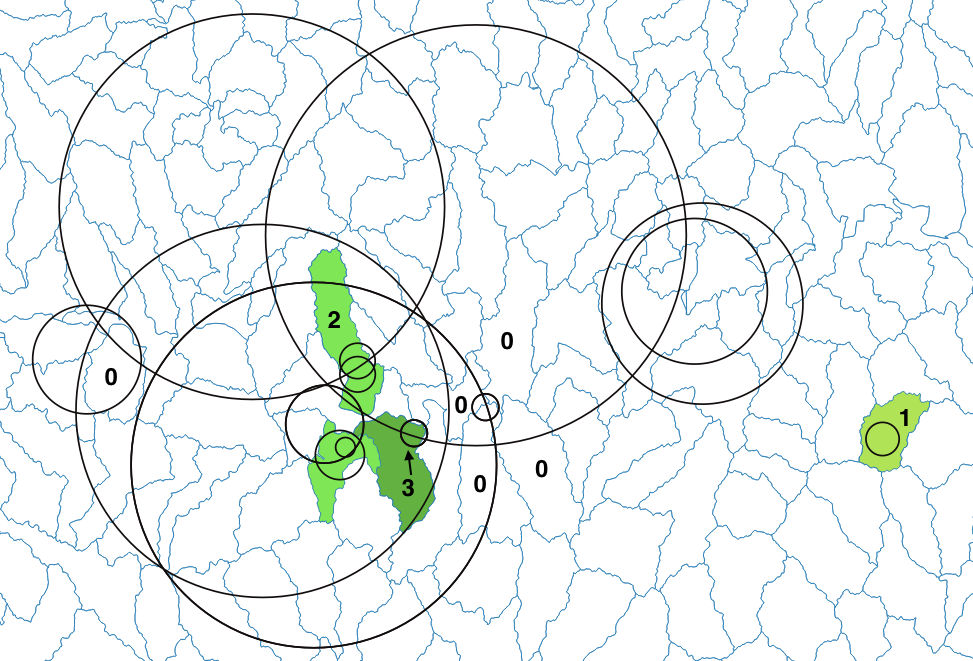

In [11]:
print("The 'proportion in polygon method' illustrated")
Image("/users/nmtarr/Documents/RANGES/Fig1.png")

In [ ]:
#%run 'eval_gbif1.py'
connr = sqlite3.connect('/users/nmtarr/documents/ranges/outputs/bybcux_range.sqlite')
df4 = pd.read_sql_query(sql="SELECT strHUC12RNG AS HUC12RNG, "
                                    "intGAPOrigin AS Origin, intGAPPresence AS Presence, "
                                    "intGAPReproduction AS Reproduction,"
                                    "intGAPSeason AS Season, eval_gbif1_cnt, eval_gbif1, "
                                    "validated_presence AS validated_pres FROM new_range WHERE eval_gbif1_cnt >=0", con=connr)
df4.set_index(["HUC12RNG"], inplace=True)
print("Tabular results of the evaluation")
print(df4)

In [ ]:
print("Mapped results of the evaluation.")
shp3 = {'file': '{0}{1}_eval_gbif1'.format(outDir, gap_id), 'column': 'eval_gbif1',
        'alias': 'eval_gbif1', 'column_colors': {1: 'b', 0: 'r'}, 
        'value_alias': {1:'Agreement', 0:'Disagreement'}, 'drawbounds': False, 
        'marker': "s"}
title="Yellow-billed Cuckoo -- eval_gbif1"
functions.MapShapefilePolygons(map_these=[shp1, shp3], title=title)

# 5. Characterize the Occurrence Records Used
With the documentation created in the previous steps, we can describe the data used in the evaluation (__eval_gbif1__).  The questions answered below characterize the data.

### Where were records retrieved from for the evaluation?

In [ ]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = cursorjup.execute("SELECT filter_sets FROM evaluations WHERE evaluation_id = 'eval_gbif1'").fetchone()[0]
filter_sets = filter_sets.split(",")

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

### What was the filtering criteria for the data used in the evaluation?

In [ ]:
filter_sets = cursorjup.execute("SELECT filter_sets FROM evaluations WHERE evaluation_id = 'eval_gbif1'").fetchone()[0]
filter_sets = filter_sets.split(",")

tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns=[x[0] for x in columns]   
        for col in columns:
            try:
                df1 = pd.read_sql_query(sql="SELECT * FROM {0} WHERE {1} = '{2}'".format(tab, col, s), con=connjup)
                print(df1.iloc[0]) 
                print('\n')
            except:
                pass

### How many records made it through the filters?

In [ ]:
conn_occ= sqlite3.connect(outDir + species_id + "_occurrences.sqlite")
curs_occ = conn_occ.cursor()
record_count = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences WHERE species_id = '{0}'".format(species_id)).fetchone()
print(str(record_count[0]) + " records made it through the filters")

### What years were represented in the data?

In [ ]:
occ_years = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%Y', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_years, bins=20)
plt.ylabel("number of occurrences")
plt.xlabel("year")
plt.title("Occurrences per Year")

### What months were represented in the data?

In [ ]:
occ_months = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%m', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of occurrences")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

### What issues were present in the data?

In [ ]:
conn_occ= sqlite3.connect(outDir + species_id + "_occurrences.sqlite")
curs_occ = conn_occ.cursor()
occ_ids = [x[0] for x in curs_occ.execute("SELECT occ_id FROM occurrences").fetchall()]
issues = set([])
for id in occ_ids:
    occdict = occurrences.get(key=id)
    issues = issues | set(occdict['issues'])
for x in list(issues):
    print(x)

### What were the bases of the records?

In [ ]:
occ_ids = [x[0] for x in curs_occ.execute("SELECT occ_id FROM occurrences").fetchall()]
bases = []
for id in occ_ids:
    occdict = occurrences.get(key=id)
    BOR = occdict['basisOfRecord']
    if BOR == "" or BOR == None:
        bases.append("UNKNOWN")
    else:
        bases.append(BOR)
for x in list(set(bases)):
    print(x)

### Who provided the records?

In [ ]:
occ_ids = [x[0] for x in curs_occ.execute("SELECT occ_id FROM occurrences").fetchall()]
by = []
for id in occ_ids:
    occdict = occurrences.get(key=id)
    try:
        who = occdict['institutionID']
        by.append(who)
    except:
        who = occdict['institutionCode']
        by.append(who)
for x in list(set(by)):
    print(x)

### Were there duplicate records?

In [ ]:
dups0 = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences GROUP BY geom_xy4326, occurrenceDate;").fetchall()
dups1 = [x[0] for x in dups0]
dups2 = [x for x in dups1 if x > 1]
print(str(len(dups2)) + ' records were duplicates based on xy coordinate and date-time')

### What were the evaluation parameters?
This answer is repeated from above

In [ ]:
df3 = pd.read_sql_query(sql="SELECT * FROM evaluations WHERE evaluation_id = 'eval_gbif1'", con=connjup)
df3.loc[0, 'years'] = df3.loc[0, 'years'][0:4] + '-' + df3.loc[0, 'years'][-4:]
print(df3.loc[0])

### How many of the records were attributable to a HUC?

In [ ]:
hucable = curs_rng.execute("SELECT SUM(eval_gbif1_cnt) FROM new_range WHERE eval_gbif1_cnt >=0").fetchall()[0]
print(str(hucable[0]) + " records were attributable to a HUC.")

### How many hucs had records attributed to them?

In [ ]:
containers = curs_rng.execute("SELECT COUNT(eval_gbif1_cnt) FROM new_range WHERE {0}_cnt >=0".format(eval_id)).fetchall()[0]
print(str(containers[0]) + " HUCs 'contained' records.")

### How many records were not used because of the minimum count?

In [ ]:
conn_rng = sqlite3.connect(outDir + gap_id + '_range.sqlite')
curs_rng = conn_rng.cursor()
ones = curs_rng.execute("SELECT SUM(eval_gbif1_cnt) FROM new_range WHERE eval_gbif1_cnt = 1").fetchall()[0]
print(str(ones[0]) + " HUCs had occurrences but were not validated because they didn't meet the minimum.")

### How many HUCs were validated?

In [ ]:
validated = curs_rng.execute("SELECT COUNT(eval_gbif1) FROM new_range WHERE {0} = 1".format(eval_id)).fetchall()[0]
print(str(validated[0]) + " HUCs were validated.")

### How many HUCs did GAP appear to omit?

In [ ]:
missed = curs_rng.execute("SELECT COUNT(eval_gbif1) FROM new_range WHERE {0} = 0".format(eval_id)).fetchall()[0]
print(str(missed[0]) + " HUCs were missed.")

### What was the maximum number of occurrences attributable to a single HUC?

In [ ]:
maxi = curs_rng.execute("SELECT MAX(eval_gbif1_cnt) FROM new_range").fetchall()[0]
print("The maximum number of records attributed to a HUC was " + str(maxi[0]))

# BONUS -- Automated Range Delineation
I generated yearly, monthly, and seasonal ranges for the yellow-billed cuckoo with spatialite's concave hull function.  Each map was stored as a record in a table (with geometry) within range evaluation database (for now).  Below is an example of a summer range map.  It does not appear useful but maybe the delineation method could be improved or integrating more occurrence records will improve it.

In [ ]:
#%run 'make_range_polygons.py'

In [ ]:
shp4 = {'file': '{0}summer_range'.format(outDir, gap_id), 'column': None,
        'alias': 'Concave hull', 'drawbounds': True, 'linewidth': 2., 'linecolor': 'k',
        'fillcolor': None, 'marker':'s'}

shp5 = {'file': '{0}summer_occs'.format(outDir, gap_id), 'column': None,
        'alias': 'Summer records', 'drawbounds': True, 'linewidth': 2., 'linecolor': 'r',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
title="Yellow-billed Cuckoo Summer Range ({0})".format(years)
functions.MapShapefilePolygons(map_these=[shp1, shp4, shp5], title=title)

# Next Steps
This is just a starting point that needs scrutiny.  It is currently hard-coded for a single species, so deploying it would require redesigning to accomodate large numbers of species, multiple users, many more occurrence records, optimal methods for evaluation and range delineation among other things.  